> I recently completed another summer internship at Meta (formerly Facebook). I was surprised to learn that one of the intern friends I met was an avid reader of my blog. Encouraged by the positive feedback from my intern friends, I decided to write another post before the end of summer. This post is dedicated to the mandem: Yassir, Amal, Ryan, Elvis, and Sam.

Today, we will take a look at [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685) by Hu et al. Alongside [bitsandbytes](https://github.com/TimDettmers/bitsandbytes), LoRA has been a key ingredient in democratizing language models like [Llama](https://ai.meta.com/llama/)[^1], making them available for both inference and fine-tuning on consumer-grade GPUs. In particular, LoRA is a prerequisite to understand [QLoRA](https://arxiv.org/abs/2305.14314), which combines int4 quantization with low-rank adaptation.

This post was heavily inspired by other great resources on LoRA:
1. sunildkumar's [lora_from_scratch](https://github.com/sunildkumar/lora_from_scratch/tree/main)
2. Hugging Face's [LoRA Concept Guide](https://huggingface.co/docs/peft/conceptual_guides/lora)
3. Chris Alexiuk's [YouTube Video](https://www.youtube.com/watch?v=dA-NhCtrrVE&t=767s)


Let's get into it!

# Recap

In this section, we will quickly recap some concepts in linear algebra, which will help us understand LoRA.

## Rank

In linear algebra, [rank](https://en.wikipedia.org/wiki/Rank_(linear_algebra)) denotes the dimension of the row and column space of the matrix. In other words, it is the number of linearly independent row or column vectors of the matrix. Another handy little fact about rank is that only full-rank matrices are invertible. To recall:

1. Row rank equals column rank;
2. A matrix is invertible if and only if it is full-rank;
3. A matrix is full-rank if and only if its determinant is non-zero.

Without getting into too much detail, the rough proof sketch for these propositions involves using reduction operations to produce diagonal matrices, and using other elementary facts about invertibility and determinants.

## Decomposition

For the purposes of understanding LoRA, it suffices to intuit rank as the amount of information encoded into a matrix from the perspective of decomposition. Concretely, consider $A$, a 4 x 4 matrix.

$$
A = \begin{pmatrix}
1 & 3 & 1 & 4 \\
2 & 7 & 3 & 9 \\
1 & 5 & 3 & 1 \\
1 & 2 & 0 & 8 \\
\end{pmatrix}
$$

In reduced echelon form, we obtain $B$:

$$
B = \begin{pmatrix}
1 & 0 & -2 & 0 \\
0 & 1 & 1 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
$$

Therefore, it is clear that $A$ is a rank 3 matrix. Then the claim is that $A$ can be decomposed into two matrices of size (4, 3) and (3, 4). Indeed, we have

$$
\begin{pmatrix}
1 & 3 & 4 \\
2 & 7 & 9 \\
1 & 5 & 1 \\
1 & 2 & 8 \\
\end{pmatrix}
\begin{pmatrix}
1 & 0 & -2 & 0 \\
0 & 1 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
=
\begin{pmatrix}
1 & 3 & 1 & 4 \\
2 & 7 & 3 & 9 \\
1 & 5 & 3 & 1 \\
1 & 2 & 0 & 8 \\
\end{pmatrix}
$$

In other words, rank determines the structure of matrix decomposition. In this example, $A$ was relatively closer to being full-rank: it was a rank 3 matrix, and the maximal rank it could have was 4. However, we can also imagine decomposing matrices with smaller rank, e.g., an $n \times n$ matrix being decomposed into $(n, m)$ and $(m, n)$, where $m \ll n$. Indeed, this is the key behind LoRA.

# LoRA

Large language models (LLMs) have become very large in recent years. Even the smaller standard LLMs, such as Llama 7B, have billions of parameters by default. Finetuning such large models for individual tasks is prohibitively expensive to say the least.

LoRA is a parameter-efficient training methodology. In short, instead of training the entire model parameters, LoRA proposes to train a few extra parameters to fuse with the activations of the original model. Let's see what this exactly means.

## Low Rank

LoRA starts from the simple hypothesis that

> the change in weights during model adaptation ... has a low “intrinsic rank”[.]

In other words, the authors of LoRA hypothesize that the delta shift in model weights during training is actually a low rank matrix. If this is true, we should be able to emulate the effects of full finetuning by simply training two small low rank matrices. This is precisely what LoRA does.

> LoRA allows us to train some dense layers in a neural network indirectly by optimizing rank decomposition matrices of the dense layers' change during adaptation instead, while keeping the pre-trained weights frozen[.]

<figure>
    <img src="https://global-uploads.webflow.com/63f3993d10c2a062a4c9f13c/64649977d084d2b4b66c6492_1*e5pYWjrZR3eA_YbCKu8deQ.png">
    <figcaption>Overview of LoRA. Image from ML6.</figcaption>
</figure>

In the diagram above, $W_\text{nk}$ is the full pretrained weight matrix. Instead of trying to finetune $W_\text{nk}$ in its entirety, LoRA instead adds to auxiliary matrices, $A$ and $B$, which have rank $r$. Let $W_\text{nk} \in \mathbb{R}^{n \times k}$. Then $A \in \mathbb{R}^{n times r}, B \in \mathbb{R}^{r \times k}$. If $r$ is small enough, then only training $A$ and $B$ will be much cheaper than training $W_\text{nk}$, i.e.,

$$
nk > r (n + k).
$$

It is easy to see that when $r = \max\{n, k\}$, then we recover the full finetuning setup. Therefore, LoRA can be seen as a generalization of full finetuning.

The authors limit the study of LoRA to the transformers architecture, testing it on a wide range of encoder and decoder models such as RoBERTa, DeBERTa, and GPT-3. They apply LoRA on the weight matrices of the self-attention module.

## Inference

The forward pass of a LoRA model can be written as

$$
h = W_\text{nk} X + AB X
$$

This is obviously different from the original unmodified forward pass, which would be

$$
h = W_\text{nk} X.
$$

We could maintain separate modules for the original weight matrix $W_\text{nk}$ and $A, B$. However, after training is complete, we can speed up the forward pass by fusing the modules to reduce FLOPs.

$$
\begin{align*}
W'_\text{nk} &= W + AB \\
h &= W'_\text{nk} X.
\end{align*}
$$

In other words, instead of maintaining the two-branch structure, we simply merge the LoRA delta matrix into the original frozen pretrained weight.

# Implementation

Now that we have an idea of how LoRA works, let's try a simple implementation with [PyTorch Lightning](https://lightning.ai/pytorch-lightning). This implementation was heavily inspired by sunildkumar's [lora_from_scratch](https://github.com/sunildkumar/lora_from_scratch/tree/main).

## Setup

In [1]:
%%capture
!pip install lightning

We import necessary dependencies and set the seed for reproducability.

In [2]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms

from torchmetrics import Accuracy

import lightning.pytorch as pl

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

pl.seed_everything(42)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


42

We will be using the MNIST toy dataset. PyTorch Lightning provides a convenient data module API, where we can pack all logic related to the data into a single class.

In [15]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = ".", batch_size: int = 1024):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.ToTensor()

    def setup(self, stage: str):
        if stage == "fit":
            mnist_full = MNIST(
                self.data_dir, train=True, download=True, transform=self.transform,
            )
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        elif stage == "test":
            self.mnist_test = MNIST(
                self.data_dir, train=False, download=True, transform=self.transform,
            )

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(self.mnist_predict, batch_size=self.batch_size)

In this dummy experiment, we will train the model on MNIST for 5 epochs. The baseline will then be continued to train on the dataset for 5 more epochs to emulate the effects of full "finetuning." The LoRA model will be initialized from the 5-epoch checkpoint, then trained for another 5 epochs.

## Pretraining

We will be training a simple dense model.

In [16]:
class MNISTModel(pl.LightningModule):
    def __init__(self, hidden_size: int = 64, lr=2e-4):
        super().__init__()
        self.lr = lr
        num_classes = 10
        self.l1 = nn.Linear(28 * 28, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)

        self.val_accuracy = Accuracy(
            task="multiclass", num_classes=num_classes,
        )
        self.test_accuracy = Accuracy(
            task="multiclass", num_classes=num_classes,
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.dropout(F.relu(self.l1(x)))
        x = F.dropout(F.relu(self.l2(x)))
        x = self.l3(x)
        return x

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

    def base_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        return x, y, logits, loss

    def training_step(self, batch, batch_idx):
         _, _, logits, loss = self.base_step(batch, batch_idx)
         self.log("train_loss", loss)
         return loss

    def validation_step(self, batch, batch_idx):
        x, y, logits, loss = self.base_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.log("val_loss", loss)
        self.log("val_acc", self.val_accuracy)

    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.base_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.log("test_loss", loss)
        self.log("test_acc", self.val_accuracy)

In [17]:
model = MNISTModel()
datamodule = MNISTDataModule()
pretrainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=5,
    logger=pl.loggers.CSVLogger("logs")
)
pretrainer.fit(model, datamodule=datamodule)
pretrainer.test(model, datamodule=datamodule)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | val_accuracy  | MulticlassAccuracy | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
--------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7035999894142151     │
│         test_loss         │    0.9380418062210083     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9380418062210083, 'test_acc': 0.7035999894142151}]

Let's read the metrics.

,train_loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,
0,2.113543,NaN,NaN,NaN,NaN
0,NaN,2.083865,0.3740,NaN,NaN
1,1.708588,NaN,NaN,NaN,NaN
1,NaN,1.654867,0.5168,NaN,NaN
2,1.350459,NaN,NaN,NaN,NaN


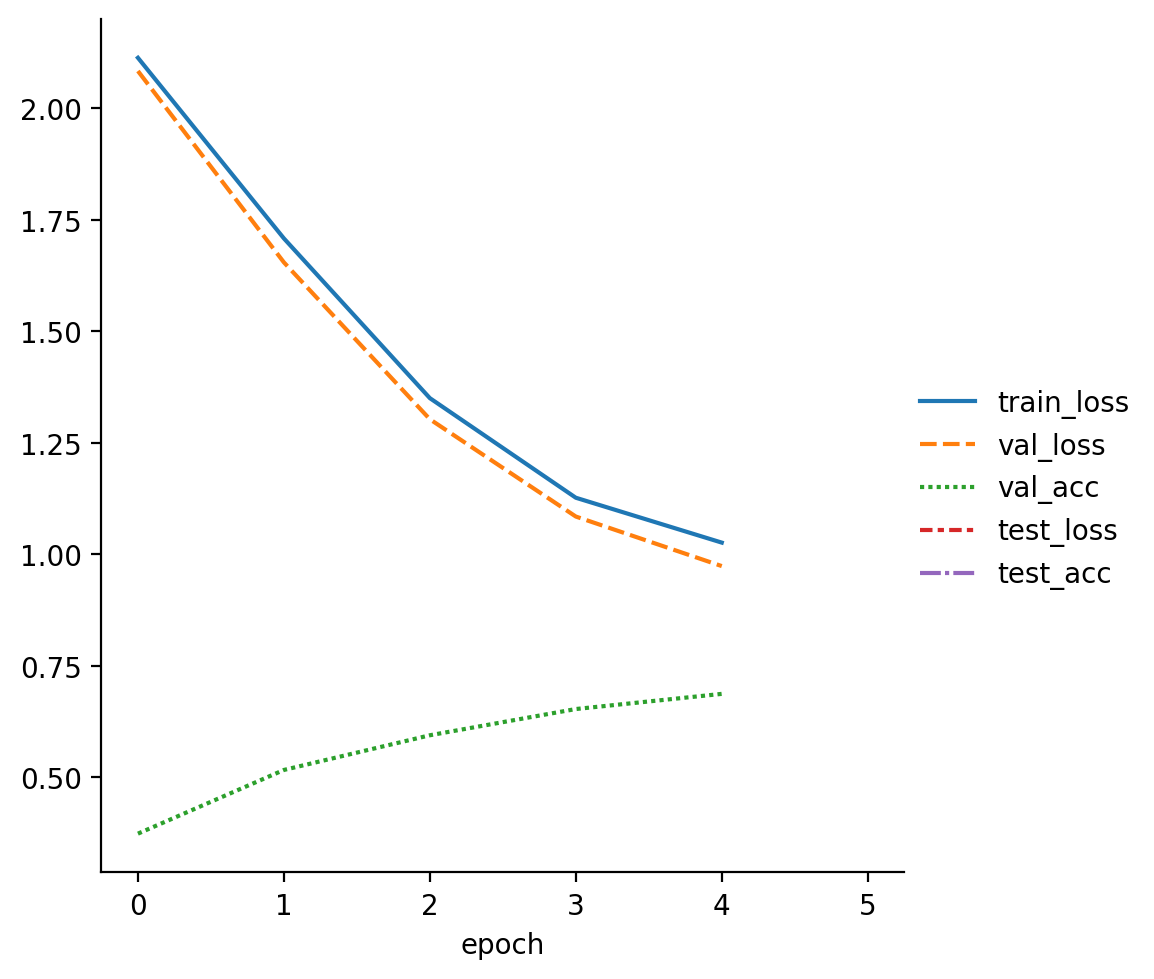

In [18]:
def read_metrics(path):
    metrics = pd.read_csv(path)
    del metrics["step"]
    metrics.set_index("epoch", inplace=True)
    display(metrics.dropna(axis=1, how="all").head())
    sns.relplot(data=metrics, kind="line")
    plt.show()

read_metrics(f"{pretrainer.logger.log_dir}/metrics.csv")

We save the model using both the PyTorch Lightning trainer API as well as the default PyTorch API. We will use the former to contiue training the model to simualte full finetuning and the latter to initialize the LoRA model from the trained checkpoint.

In [19]:
pretrainer.save_checkpoint("model.ckpt")
torch.save(model.state_dict(), 'model.pt')

## Baseline

Let's continue training the model for 5 more epochs to see how it improves. This is the full finetuning baseline.

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | val_accuracy  | MulticlassAccuracy | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
--------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


,train_loss,val_loss,val_acc
epoch,,,
0,0.920625,NaN,NaN
0,NaN,0.848711,0.7360
1,0.804315,NaN,NaN
1,NaN,0.757564,0.7658
2,0.751054,NaN,NaN


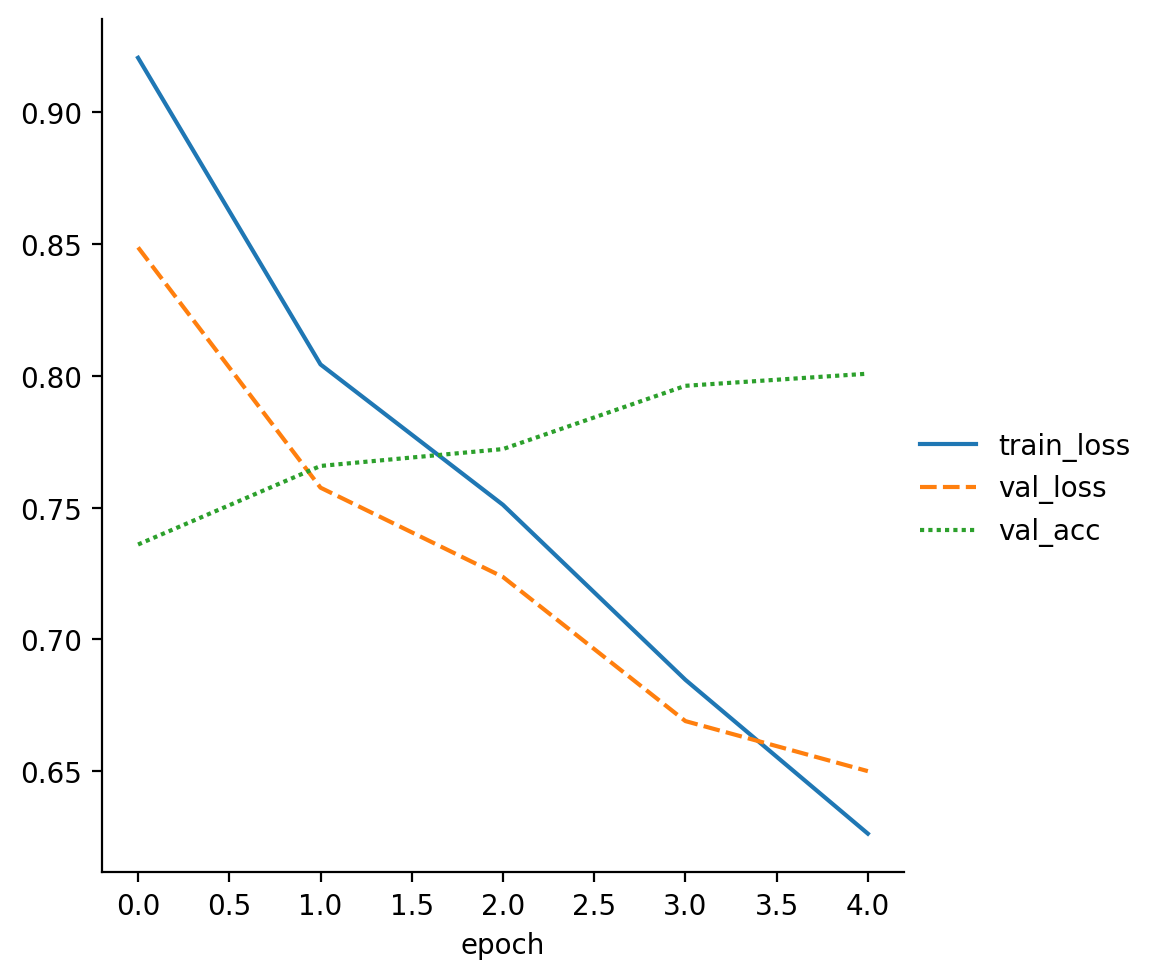

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.809499979019165     │
│         test_loss         │    0.6315763592720032     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6315763592720032, 'test_acc': 0.809499979019165}]

In [20]:
model = MNISTModel.load_from_checkpoint("model.ckpt")
trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=5,
    logger=pl.loggers.CSVLogger("logs")
)
trainer.fit(model, datamodule=datamodule)
read_metrics(f"{trainer.logger.log_dir}/metrics.csv")
trainer.test(model, datamodule=datamodule)

We see that the test accuracy improved from the previous 0.7 to around 0.81, as expected.

## LoRA

Next, we create a new LoRA model. To build the LoRA model, we will create a simple `LoRALinear` class that abstracts away the initialization and forward pass through the two low rank matrices.

In [34]:
import math

class LoRALinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, rank: int):
        super().__init__()
        self.A = nn.Parameter(torch.empty(in_features, rank))
        self.B = nn.Parameter(torch.empty(rank, out_features))
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        nn.init.zeros_(self.B)

    def forward(self, x):
        return x @ (self.A @ self.B)

The LoRA model inherits from the `MNISTModel`. We perform two steps:

1. Freeze the already trained parameters from `MNISTModel`;
2. Initialize the low rank matrices via `LoRALinear` with the specified `rank`.

During the forward process, we use an `alpha` parameter to determine how much mixing we want to perform between the activations from LoRA and the frozen pretrained model.

In [39]:
class MNISTLoRAModel(MNISTModel):
    def __init__(self, rank: int, alpha: float, hidden_size: int = 64):
        super().__init__(hidden_size)
        for name, parameter in self.named_parameters():
            parameter.requires_grad = False
        self.rank = rank
        self.alpha = alpha
        self.l1_lora = LoRALinear(28 * 28, hidden_size, self.rank)
        self.l2_lora = LoRALinear(hidden_size, hidden_size, self.rank)
        self.l3_lora = LoRALinear(hidden_size, 10, self.rank)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.dropout(F.relu(self.l1(x) + self.alpha * self.l1_lora(x)))
        x = F.dropout(F.relu(self.l2(x) + self.alpha * self.l2_lora(x)))
        x = self.l3(x) + self.alpha * self.l3_lora(x)
        return x

    def configure_optimizers(self):
        optimizer = super().configure_optimizers()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=10)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
            },
        }

Here, we set `rank` to 32 and `alpha` to 1. Let's try training the model for 5 additional epochs, just like the baseline. Note that with this LoRA configuration, we are training around 33K parameters, which is smaller than the full finetuning baseline of 55K parameters.

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | val_accuracy  | MulticlassAccuracy | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | l1_lora       | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


,train_loss,val_loss,val_acc
epoch,,,
0,0.907201,NaN,NaN
0,NaN,0.928417,0.7052
1,0.904668,NaN,NaN
1,NaN,0.876187,0.7232
2,0.812540,NaN,NaN


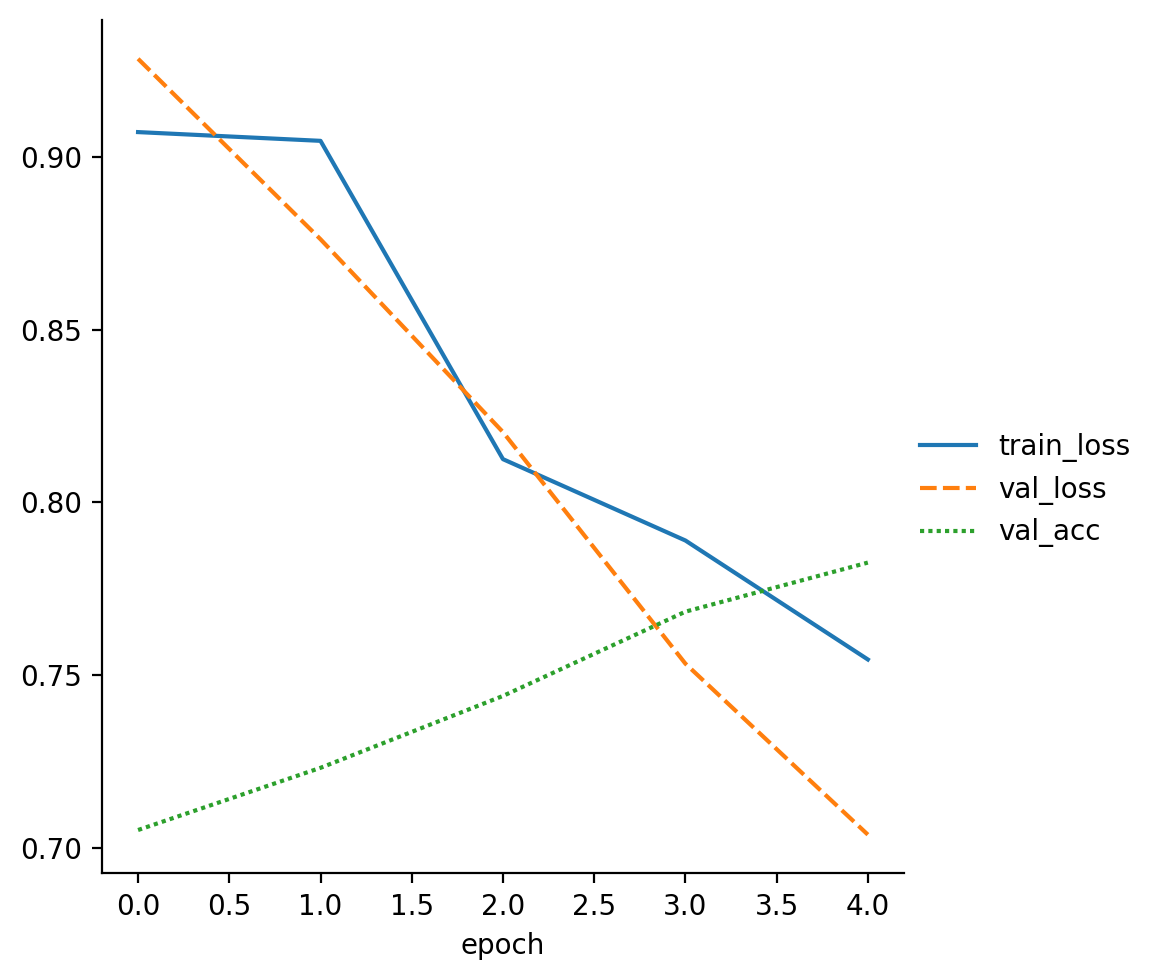

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7870000004768372     │
│         test_loss         │    0.6841080188751221     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6841080188751221, 'test_acc': 0.7870000004768372}]

In [42]:
lora_model = MNISTLoRAModel(rank=32, alpha=1)
state_dict = torch.load("model.pt")
lora_model.load_state_dict(state_dict, strict=False)
datamodule = MNISTDataModule()
lora_trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=5,
    logger=pl.loggers.CSVLogger("logs"),
)
lora_trainer.fit(lora_model, datamodule=datamodule)
read_metrics(f"{lora_trainer.logger.log_dir}/metrics.csv")
lora_trainer.test(lora_model, datamodule=datamodule)

The test accuracy is around 0.79, which is just 0.02 points shy of the score achieved by the full finetuning baseline model.

One would expect LoRA to more closely match the performance of the baseline with larger rank. Let's continue the experiment with different ranks to verify this hypothesis. Below, we repeat the experiment with ranks 1, 2, 4, 8, 16, 32, and 64.

In [46]:
def run_lora(rank):
    lora_model = MNISTLoRAModel(rank=rank, alpha=1)
    state_dict = torch.load("model.pt")
    lora_model.load_state_dict(state_dict, strict=False)
    datamodule = MNISTDataModule()
    lora_trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=5,
    )
    lora_trainer.fit(lora_model, datamodule=datamodule)
    return lora_trainer.test(lora_model, datamodule=datamodule)[0]["test_acc"]

ranks = [1, 2, 4, 8, 16, 32, 64]
test_accs = [run_lora(rank) for rank in ranks]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | val_accuracy  | MulticlassAccuracy | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | l1_lora       | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7034000158309937     │
│         test_loss         │    0.9224669933319092     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | val_accuracy  | MulticlassAccuracy | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | l1_lora       | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7060999870300293     │
│         test_loss         │    0.9172080159187317     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | val_accuracy  | MulticlassAccuracy | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | l1_lora       | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7181000113487244     │
│         test_loss         │    0.8910029530525208     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | val_accuracy  | MulticlassAccuracy | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | l1_lora       | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7369999885559082     │
│         test_loss         │    0.8262072205543518     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | val_accuracy  | MulticlassAccuracy | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | l1_lora       | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7551000118255615     │
│         test_loss         │    0.7744984030723572     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | val_accuracy  | MulticlassAccuracy | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | l1_lora       | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.785099983215332     │
│         test_loss         │    0.6795159578323364     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | val_accuracy  | MulticlassAccuracy | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | l1_lora       | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8148000240325928     │
│         test_loss         │    0.6076363325119019     │
└───────────────────────────┴───────────────────────────┘

Plotting the results, we see that LoRA indeed reaches the baseline when we give it full rank of 64; in fact, when rank is 64, the number of trainable parameters exceeds that of the baseline since we essentially have two full rank matrices instead of 1, and we see that LoRA outperforms the baseline. It is clear that as the rank increases, LoRA's performance more closely matches that of the baseline.

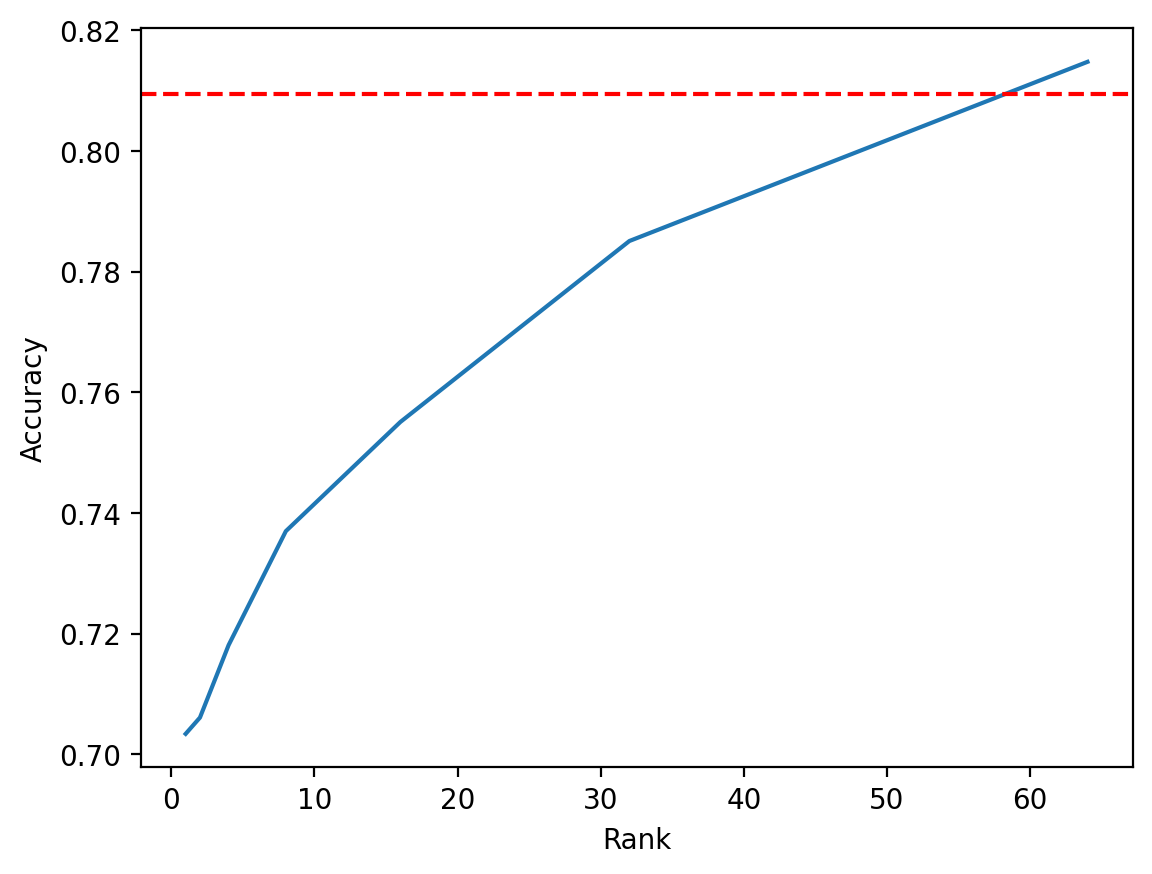

In [50]:
plt.plot(ranks, test_accs)
plt.axhline(y=0.809499979019165, color="r", linestyle="--")
plt.xlabel("Rank")
plt.ylabel("Accuracy")
plt.show()

# Conclusion

In this post, we explored LoRA, a parameter efficient finetuning methodology. The beauty of LoRA is in its simplicity—it is motiviated by a simple heuristic, and it is relatively straightforward to implement in practice. LoRA has been applied to a variety of architectures, including LLMs and [Stable Diffusion](https://huggingface.co/blog/lora). This is in part because LoRA has been primarily battle-tested in self-attention modules, which are used in both LLMs and text-to-image models. Through this experiment, we also saw that rank is an important hyperparameter that effectively represents a tradeoff between model performance and computational cost: the higher the rank, the larger the number of parameters.

LoRA was further improved and explored in follow-up papers such as [QLoRA: Efficient Finetuning of Quantized LMs](https://arxiv.org/abs/2305.14314) by Dettmers et al. These developments have really contributed to the democratization of LLMs: people can now consider finetuning LMs on consumer-grade GPUs from the comfort of their homes. This year, we have also seen an exponential number of Llama variants too many to name, which has invigorated the open source community to reproduce, match, and sometimes even outperform closed models like GPT-3.5 or GPT-4. This is an exciting development, and I am excited to see more breakthroughs to come.